In [1]:
import GPy
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True,precision=3)
%matplotlib inline


warning in stationary: failed to import cython module: falling back to numpy


We begin with $A$, the initial kernel (covariance) matrix.
For convenience $A$ includes the covariance between three points, two training (at x[0] and x[2]) and we later reuse the training points as test points (x[:]).

In [19]:
A = np.zeros([3,3])
x = np.array([1,2,3])
for i in range(3):
    for j in range(3):
        A[i,j] = np.exp(-(x[i]-x[j])**2)

In [20]:
A

array([[ 1.   ,  0.368,  0.018],
       [ 0.368,  1.   ,  0.368],
       [ 0.018,  0.368,  1.   ]])

Here we slice up A into the covariance between training points $K$, and between training and test points $K_*$. $\mathbf{y}$ is the training output values.

In [21]:
K = A[[0,2],:][:,[0,2]]
K_star = A[:,[0,2]]
y = np.array([1,2])-1.5

In [22]:
print K
print K_star

[[ 1.     0.018]
 [ 0.018  1.   ]]
[[ 1.     0.018]
 [ 0.368  0.368]
 [ 0.018  1.   ]]


### The DP bit

Here we find the bound on the sensitivity, "scale". We scale our covariances $A$ with this scale, so that the variance at the relevant locations is scaled appropriately. Previously we wanted to try and scale the sample for each test point, this isn't valid, so instead we are scaling the variance of each test point in the GP's covariance function.

To generate the noise using the cloaking idea; I'm scaling a sample $G(\mathbf{x_*})$ from a zero-mean GP by some function $\mathbf{\Delta}(\mathbf{x})$. The test points vector of $D=\text{diag}(\mathbf{\Delta}(\mathbf{x_*}))$ can be represented directly as samples from a GP with zero-mean and a covariance of $K_{new} = D K D^T$.

Can we actually write the above GP's kernel we are going to use as a non-stationary kernel (with a covariance that depends in some way on $x$ and $x'$), (but still with zero mean) such that the scale of the variance for any sample will be greater than $\Delta(x)$ for all x. Then we use this kernel to start again: 

   a. make predictions (as normal using the training and test data), then 
   b. use it to generate the DP noise (as we're still now in the same RKHS).
   
Although we are now using a constant $\Delta$, the kernel covariance function will have small values around our training data. I don't know if that will definitely work, as we will still be restricted by a potentially still quite brutal bound on $\Delta$. 

In [23]:
scale = np.max(np.abs(np.dot(K_star,np.linalg.inv(K))),1)
A = np.dot(np.dot(np.diag(scale),A),np.diag(scale))

In [24]:
print scale

[ 1.     0.361  1.   ]


In [25]:
A

array([[ 1.   ,  0.133,  0.018],
       [ 0.133,  0.131,  0.133],
       [ 0.018,  0.133,  1.   ]])

In [26]:
K = A[[0,2],:][:,[0,2]]
k_star = A[1,[0,2]]
k_star = A[0,[0,2]]

Ensure prediction still works with the new funky kernel;

In [28]:
np.dot(np.dot(k_star.T,np.linalg.inv(K)),y)

-0.49999999999999994

The noise we need to add is far less,

In [29]:
np.diag(A)

array([ 1.   ,  0.131,  1.   ])

only 0.13 compared to the noise at the two other points of 1.

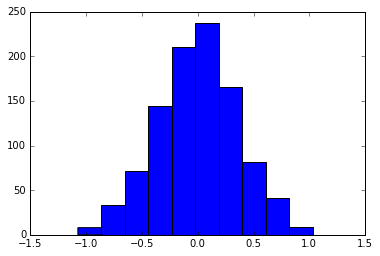

In [12]:
noise = []
for it in range(1000):
    noise.append(np.random.multivariate_normal(np.zeros(1),A[1,1][None,None]))
noise = np.array(noise)
plt.hist(noise);